In [85]:
#Local
from format_tools import raw_formatter

#Global
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import arff
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.metrics import silhouette_score, plot_confusion_matrix, plot_roc_curve, classification_report, recall_score, make_scorer
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import pickle as pkl

# Data Preparation

In [86]:
data = pd.read_csv('data2020.student.csv')
data = data.loc[0:999,:]

data['Class'] = data['Class'].astype('category')

In [87]:
to_rem = []
num_cols = []
cat_cols = []

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      1000 non-null   int64   
 1   Class   1000 non-null   category
 2   C1      995 non-null    float64 
 3   C2      996 non-null    float64 
 4   C3      1000 non-null   object  
 5   C4      1000 non-null   int64   
 6   C5      1000 non-null   object  
 7   C6      1000 non-null   int64   
 8   C7      1000 non-null   object  
 9   C8      1000 non-null   int64   
 10  C9      1000 non-null   int64   
 11  C10     1000 non-null   object  
 12  C11     1000 non-null   object  
 13  C12     1000 non-null   object  
 14  C13     1000 non-null   int64   
 15  C14     995 non-null    object  
 16  C15     1000 non-null   int64   
 17  C16     1000 non-null   object  
 18  C17     1000 non-null   object  
 19  C18     1000 non-null   object  
 20  C19     996 non-null    object  
 21  C20     1000 no

## Removing attributes with no information.

In [89]:
for col in data:
    if len(data[col].value_counts()) == 1:
        print(col)
        data = data.drop(col,axis=1)
        to_rem.append(col)

C15
C17
C21
C22


C28 will be removed as it has very few recorded values and possesses inputs in the prediction set that do not appear in the training set. C29 will be removed as it possess less than 1% recorded values.

In [90]:
data = data.drop('C28', axis=1)
to_rem.append('C28')

data = data.drop('C29', axis=1)
to_rem.append('C29')

## Determining object attributes that should be categorical

In [91]:
for col in data.select_dtypes(include=object):
    print(col)
    data[col] = data[col].astype(object)

C3
C5
C7
C10
C11
C12
C14
C16
C18
C19
C23
C25
C27
C31
C32


## Determining numeric attributes that should be categrocial

In [92]:
for col in data.select_dtypes(include=np.number):
    if data[col].nunique() < 6:
        print(col)
        data[col] = data[col].astype(object)

C2
C4
C9
C24


In [93]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 28 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      1000 non-null   int64   
 1   Class   1000 non-null   category
 2   C1      995 non-null    float64 
 3   C2      996 non-null    object  
 4   C3      1000 non-null   object  
 5   C4      1000 non-null   object  
 6   C5      1000 non-null   object  
 7   C6      1000 non-null   int64   
 8   C7      1000 non-null   object  
 9   C8      1000 non-null   int64   
 10  C9      1000 non-null   object  
 11  C10     1000 non-null   object  
 12  C11     1000 non-null   object  
 13  C12     1000 non-null   object  
 14  C13     1000 non-null   int64   
 15  C14     995 non-null    object  
 16  C16     1000 non-null   object  
 17  C18     1000 non-null   object  
 18  C19     996 non-null    object  
 19  C20     1000 non-null   int64   
 20  C23     1000 non-null   object  
 21  C24     1000 no

## Removing ID column

In [94]:
data = data.drop('ID',1)
to_rem.append('ID')

## Searching for dependence structures between numeric attributes

In [95]:
tmp = data.select_dtypes(include=np.number).copy()
tmp = tmp.dropna()

In [96]:
Q,R = np.linalg.qr(tmp.select_dtypes(include=np.number))
cols=[]
for i in range(0, len(R)):
    if abs(R[i,i]) < 1e-10:
        cols.append(data.select_dtypes(include=np.number).columns[i])

print('Columns: ' + str(data.select_dtypes(include=np.number).columns))
print('Dependent Columns: ' + str(cols))

pd.DataFrame(R)

Columns: Index(['C1', 'C6', 'C8', 'C13', 'C20', 'C26', 'C30'], dtype='object')
Dependent Columns: ['C6', 'C30']


,0,1,2,3,4,5,6
0,-742.374569,-7.423746e+02,-118672.370707,-136398.275604,-948.255813,-1.085716e+06,-1.186724e+05
1,0.000000,-1.613424e-13,-585.313103,2222.630197,4.748799,1.984396e+04,-5.853131e+02
2,0.000000,0.000000e+00,-68689.142485,-2677.276329,-56.297503,-2.452912e+04,-6.868914e+04
3,0.000000,0.000000e+00,0.000000,-87425.983024,-535.643648,-6.664145e+05,-5.784380e-13
4,0.000000,0.000000e+00,0.000000,0.000000,-420.421022,-1.151557e+05,-2.237495e-13
5,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-9.665657e+05,3.020302e-13
6,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-1.734832e-11


From the QR decomposition we can observe that C6 is dependent on C1. Given C1 has missing entries we can remove it from the dataset in favour of C1.

In [97]:
to_rem.append('C1')
to_rem.append('C30')

data = data.drop(['C1','C30'],axis=1)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Class   1000 non-null   category
 1   C2      996 non-null    object  
 2   C3      1000 non-null   object  
 3   C4      1000 non-null   object  
 4   C5      1000 non-null   object  
 5   C6      1000 non-null   int64   
 6   C7      1000 non-null   object  
 7   C8      1000 non-null   int64   
 8   C9      1000 non-null   object  
 9   C10     1000 non-null   object  
 10  C11     1000 non-null   object  
 11  C12     1000 non-null   object  
 12  C13     1000 non-null   int64   
 13  C14     995 non-null    object  
 14  C16     1000 non-null   object  
 15  C18     1000 non-null   object  
 16  C19     996 non-null    object  
 17  C20     1000 non-null   int64   
 18  C23     1000 non-null   object  
 19  C24     1000 non-null   object  
 20  C25     1000 non-null   object  
 21  C26     1000 no

## Removing duplicate data

In [99]:
print(data.shape)
data = data.drop_duplicates()

print(data.T.duplicated())
data = data.loc[:,~data.T.duplicated()]
print(data.shape)

(1000, 25)
Class    False
C2       False
C3       False
C4       False
C5       False
C6       False
C7       False
C8       False
C9       False
C10      False
C11      False
C12      False
C13      False
C14      False
C16       True
C18      False
C19      False
C20      False
C23      False
C24      False
C25      False
C26      False
C27       True
C31      False
C32      False
dtype: bool
(900, 23)


## Assigning columns to categorical or numeric

In [100]:
for col in data:
    if pd.api.types.is_numeric_dtype(data[col]):
        num_cols.append(col)
    elif col != 'Class':
        cat_cols.append(col)

## Imputing missing entries

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 899
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Class   900 non-null    category
 1   C2      896 non-null    object  
 2   C3      900 non-null    object  
 3   C4      900 non-null    object  
 4   C5      900 non-null    object  
 5   C6      900 non-null    int64   
 6   C7      900 non-null    object  
 7   C8      900 non-null    int64   
 8   C9      900 non-null    object  
 9   C10     900 non-null    object  
 10  C11     900 non-null    object  
 11  C12     900 non-null    object  
 12  C13     900 non-null    int64   
 13  C14     895 non-null    object  
 14  C18     900 non-null    object  
 15  C19     896 non-null    object  
 16  C20     900 non-null    int64   
 17  C23     900 non-null    object  
 18  C24     900 non-null    object  
 19  C25     900 non-null    object  
 20  C26     900 non-null    int64   
 21  C31     900 non-

In [102]:
data[cat_cols] = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='Unknown').fit_transform(data[cat_cols])
data[num_cols] = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(data[num_cols])

In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 899
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Class   900 non-null    category
 1   C2      900 non-null    object  
 2   C3      900 non-null    object  
 3   C4      900 non-null    int64   
 4   C5      900 non-null    object  
 5   C6      900 non-null    float64 
 6   C7      900 non-null    object  
 7   C8      900 non-null    float64 
 8   C9      900 non-null    int64   
 9   C10     900 non-null    object  
 10  C11     900 non-null    object  
 11  C12     900 non-null    object  
 12  C13     900 non-null    float64 
 13  C14     900 non-null    object  
 14  C18     900 non-null    object  
 15  C19     900 non-null    object  
 16  C20     900 non-null    float64 
 17  C23     900 non-null    object  
 18  C24     900 non-null    int64   
 19  C25     900 non-null    object  
 20  C26     900 non-null    float64 
 21  C31     900 non-

## Plotting Pairs

In [104]:
#sbplot = sb.pairplot(data, hue = 'Class',diag_kws={'bw': 1})
#sbplot.savefig('exploratory.jpg')

## Performing hot encoding

In [105]:
dataEnc = OneHotEncoder().fit(data[cat_cols].astype(str))
data = data.reset_index(drop=True)

In [106]:
data = data.drop(cat_cols,axis=1).join(pd.DataFrame(dataEnc.transform(data[cat_cols].astype(str)).toarray()))

## Checking for class imbalance

In [107]:
data['Class'].value_counts()

0.0    650
1.0    250
Name: Class, dtype: int64

## Splitting test and training 


In [108]:
train_data, test_data = train_test_split(data,test_size = 0.15, stratify = data['Class'], random_state = 21)

In [109]:
train_data['Class'].value_counts()

0.0    553
1.0    212
Name: Class, dtype: int64

## Performing Synthetic Minority Oversampling

In [110]:
y_train = train_data['Class']
x_train = train_data.drop('Class',axis=1)
x_train, y_train = SMOTE(random_state=927).fit_resample(x_train, y_train)

y_train.value_counts()

1.0    553
0.0    553
Name: Class, dtype: int64

## Standardising numeric training and test data

In [111]:
dataScaler = StandardScaler().fit(x_train[num_cols])

In [112]:
x_train[num_cols] = dataScaler.transform(x_train[num_cols])

## Performing PCA on data

['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
[0.33034203 0.21346807 0.2011705  0.18308772 0.07193169]


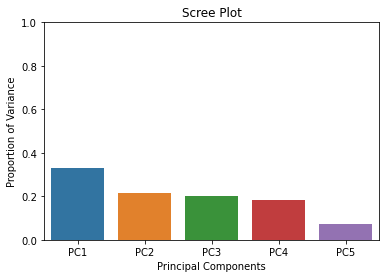

In [122]:
dataPCA = PCA().fit(x_train[num_cols])
print(['PC'+str(i) for i in range(1,6)])
print(dataPCA.explained_variance_ratio_)

sb.barplot(x=['PC'+str(i) for i in range(1,6)], y=dataPCA.explained_variance_ratio_)
plt.ylim(0,1)
plt.xlabel('Principal Components')
plt.ylabel('Proportion of Variance')
plt.title('Scree Plot')
plt.show()

In [114]:
x_train[num_cols].cov()

,C6,C8,C13,C20,C26
C6,1.000905,0.634972,-0.012737,0.015106,-0.050197
C8,0.634972,1.000905,-0.019942,0.101628,-0.039198
C13,-0.012737,-0.019942,1.000905,-0.013240,0.066617
C20,0.015106,0.101628,-0.013240,1.000905,0.032131
C26,-0.050197,-0.039198,0.066617,0.032131,1.000905


In [115]:
x_train[num_cols] = dataPCA.transform(x_train[num_cols])

In [116]:
x_train[num_cols].cov()

,C6,C8,C13,C20,C26
C6,1.653205e+00,-1.221748e-16,7.025049e-16,-8.158381e-16,-6.229306e-16
C8,-1.221748e-16,1.068306e+00,-1.060991e-16,3.279428e-16,-8.037814e-18
C13,7.025049e-16,-1.060991e-16,1.006763e+00,-7.266184e-16,5.385335e-17
C20,-8.158381e-16,3.279428e-16,-7.266184e-16,9.162671e-01,-6.108738e-17
C26,-6.229306e-16,-8.037814e-18,5.385335e-17,-6.108738e-17,3.599839e-01


## Performing cluster analysis

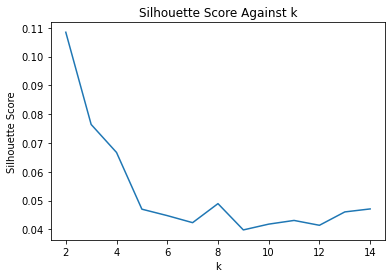

In [32]:
sil = []
ks = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k,random_state=67).fit(x_train)
    sil.append(silhouette_score(x_train,kmeans.labels_,metric='manhattan'))
    ks.append(k)
plt.plot(ks,sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Against k')
plt.show()


In [33]:
#kmeans = KMeans(n_clusters=2,random_state=67).fit(train_data)

In [34]:
#train_data['Cluster'] = kmeans.predict(train_data)
#test_data['Cluster'] = kmeans.predict(test_data)

Given that the silhouette plot demonstrates no global optimum clustering is removed from model.

# Analysis

In [35]:
cv = KFold(n_splits=10, random_state=758, shuffle=True)
macro_recall = make_scorer(recall_score, average='macro')

In [36]:

#Building raw formatter
data = pd.read_csv('data2020.student.csv')
data = data.loc[0:999,:]
data['Class'] = data['Class'].astype('category')
rfrmt = raw_formatter()
data = rfrmt.fit_transform(data, 'Class', num_cols, cat_cols)

#Splitting test and training
train_data, test_data = train_test_split(data,test_size = 0.15, stratify = data['Class'], random_state = 79)
print(train_data['Class'].value_counts())

y_train = train_data['Class']
x_train = train_data.drop('Class',axis=1)

y_test = test_data['Class']
x_test = test_data.drop('Class',axis=1)

0.0    553
1.0    212
Name: Class, dtype: int64


## Building data pipelines

In [37]:
numerical_transform = Pipeline(steps=[
    ('Standardisation', StandardScaler()),
    ('Principal Component Analysis', PCA())
])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric Transformations', numerical_transform, num_cols)
], remainder='passthrough', n_jobs=-1)

### Naive Bayes

In [38]:
cnb = Pipeline(steps=[
    ('SMOTE', SMOTE(random_state=927)),
    ('Numeric Transformations', preprocessor),
    ('NB', GaussianNB())
])

cnb = cnb.fit(x_train,y_train)

In [39]:
print('\n')
print('Naive Bayes Train Data Report')
print(classification_report(y_pred = cnb.predict(x_train), y_true = y_train))

print('\n')
print('Naive Bayes Test Data Report')
print(classification_report(y_pred = cnb.predict(x_test), y_true = y_test))



Naive Bayes Train Data Report
              precision    recall  f1-score   support

         0.0       0.92      0.20      0.33       553
         1.0       0.31      0.95      0.47       212

    accuracy                           0.41       765
   macro avg       0.62      0.58      0.40       765
weighted avg       0.75      0.41      0.37       765



Naive Bayes Test Data Report
              precision    recall  f1-score   support

         0.0       0.79      0.20      0.31        97
         1.0       0.30      0.87      0.44        38

    accuracy                           0.39       135
   macro avg       0.54      0.53      0.38       135
weighted avg       0.65      0.39      0.35       135



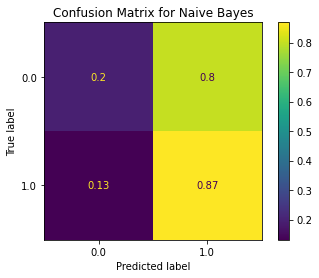

In [40]:
plot_confusion_matrix(cnb,x_test,y_test, normalize='true')
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

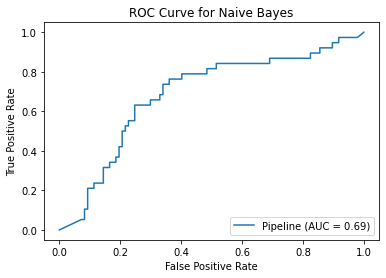

In [41]:
plot_roc_curve(cnb,x_test,y_test)
plt.title('ROC Curve for Naive Bayes')
plt.show()

### k-Nearest Neighbours Classifier

In [42]:
#Optimising model in region about default values
params = {
    'KNN__n_neighbors' : [i for i in range(5,10)],
    'KNN__leaf_size' : [i for i in range(25,35)]
}

knn = Pipeline(steps=[
    ('SMOTE', SMOTE(random_state=927)),
    ('Numeric Transformations', preprocessor),
    ('KNN', KNeighborsClassifier())
])

gd_sr = GridSearchCV(estimator=knn,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall)
gd_sr.fit(x_train,y_train)
knn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'KNN__leaf_size': 25, 'KNN__n_neighbors': 6}


In [43]:
print('\n')
print('k-Nearest Neighbours Train Data Report')
print(classification_report(y_pred = knn.predict(x_train), y_true = y_train))

print('\n')
print('k-Nearest Neighbours Test Data Report')
print(classification_report(y_pred = knn.predict(x_test), y_true = y_test))



k-Nearest Neighbours Train Data Report
              precision    recall  f1-score   support

         0.0       0.94      0.67      0.78       553
         1.0       0.51      0.90      0.65       212

    accuracy                           0.73       765
   macro avg       0.73      0.78      0.71       765
weighted avg       0.82      0.73      0.74       765



k-Nearest Neighbours Test Data Report
              precision    recall  f1-score   support

         0.0       0.85      0.58      0.69        97
         1.0       0.41      0.74      0.52        38

    accuracy                           0.62       135
   macro avg       0.63      0.66      0.61       135
weighted avg       0.72      0.62      0.64       135



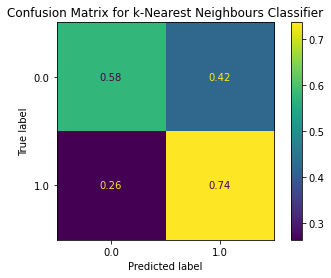

In [44]:
plot_confusion_matrix(knn,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for k-Nearest Neighbours Classifier')
plt.show()

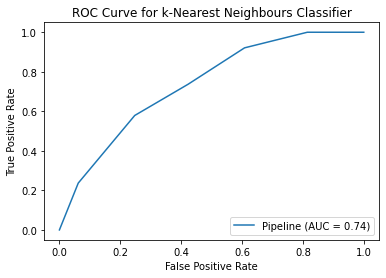

In [45]:
plot_roc_curve(knn,x_test,y_test)
plt.title('ROC Curve for k-Nearest Neighbours Classifier')
plt.show()

### Logistic Regression

In [46]:
#Optimising model in region about default values
params = {
    'LR__C' : [i/10 for i in range(0,11)]
}

clf = Pipeline(steps=[
    ('SMOTE', SMOTE(random_state=927)),
    ('Numeric Transformations', preprocessor),
    ('LR', LogisticRegression(random_state=82))
])

gd_sr = GridSearchCV(estimator=clf,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall)
gd_sr.fit(x_train,y_train)
clf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'LR__C': 0.1}


In [47]:
print('Logistic Regression')

print('\n')
print('Logistic Regression Train Data Report')
print(classification_report(y_pred = clf.predict(x_train), y_true = y_train))

print('\n')
print('Logistic Regression Test Data Report')
print(classification_report(y_pred = clf.predict(x_test), y_true = y_test))

Logistic Regression


Logistic Regression Train Data Report
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82       553
         1.0       0.55      0.79      0.65       212

    accuracy                           0.77       765
   macro avg       0.73      0.77      0.74       765
weighted avg       0.81      0.77      0.78       765



Logistic Regression Test Data Report
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81        97
         1.0       0.54      0.79      0.64        38

    accuracy                           0.75       135
   macro avg       0.72      0.76      0.72       135
weighted avg       0.80      0.75      0.76       135



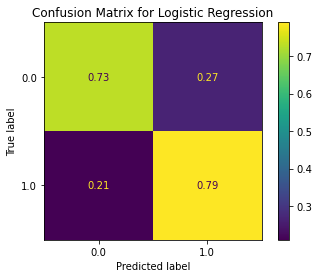

In [48]:
plot_confusion_matrix(clf,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

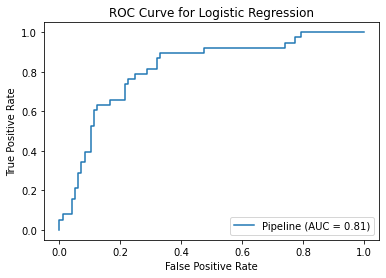

In [49]:
plot_roc_curve(clf,x_test,y_test)
plt.title('ROC Curve for Logistic Regression')
plt.show()

### Decision Tree

In [50]:
#Optimising model in region about default values
params = {
    'DT__criterion' : ['gini', 'entropy'],   
    'DT__min_samples_split' : [i for i in range(2,5)] 
}

ctr = Pipeline(steps=[
    ('SMOTE', SMOTE(random_state=927)),
    ('Numeric Transformation', preprocessor),
    ('DT', DecisionTreeClassifier(random_state=387))
])

gd_sr = GridSearchCV(estimator=ctr,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall)
gd_sr.fit(x_train,y_train)
ctr = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'DT__criterion': 'entropy', 'DT__min_samples_split': 3}


In [51]:
print('\n')
print('Decision Tree Train Data Report')
print(classification_report(y_pred = ctr.predict(x_train), y_true = y_train))

print('\n')
print('Decision Tree Test Data Report')
print(classification_report(y_pred = ctr.predict(x_test), y_true = y_test))



Decision Tree Train Data Report
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       553
         1.0       1.00      0.99      0.99       212

    accuracy                           1.00       765
   macro avg       1.00      0.99      1.00       765
weighted avg       1.00      1.00      1.00       765



Decision Tree Test Data Report
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79        97
         1.0       0.48      0.53      0.50        38

    accuracy                           0.70       135
   macro avg       0.64      0.65      0.64       135
weighted avg       0.71      0.70      0.71       135



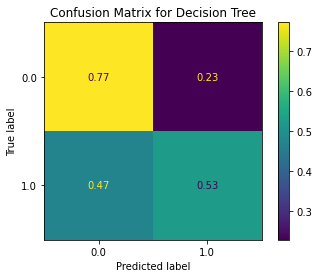

In [52]:
plot_confusion_matrix(ctr,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

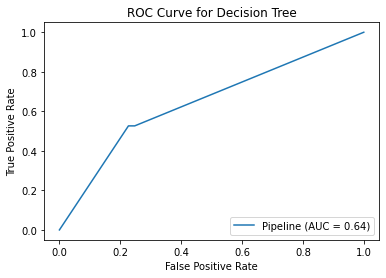

In [53]:
plot_roc_curve(ctr,x_test,y_test)
plt.title('ROC Curve for Decision Tree')
plt.show()

### Neural Network

In [54]:
#Optimising model in region about default values
params = {
    'NN__solver' : ['lbfgs', 'sgd', 'adam'],
    'NN__hidden_layer_sizes' : [(90,),(100,),(110,),(90,90),(100,100),(110,110),(90,90,90),(100,100,100),(110,110,110)]
}

cnn = Pipeline(steps=[
    ('SMOTE', SMOTE(random_state=927)),
    ('Numeric Transformations', preprocessor),
    ('NN', MLPClassifier(random_state=29))
])

gd_sr = GridSearchCV(estimator=cnn,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall)
gd_sr.fit(x_train,y_train)
cnn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'NN__hidden_layer_sizes': (100, 100, 100), 'NN__solver': 'sgd'}


In [55]:
print('\n')
print('Neural Network Train Data Report')
print(classification_report(y_pred = cnn.predict(x_train), y_true = y_train))

print('\n')
print('Neural Network Test Data Report')
print(classification_report(y_pred = cnn.predict(x_test), y_true = y_test))



Neural Network Train Data Report
              precision    recall  f1-score   support

         0.0       0.91      0.79      0.85       553
         1.0       0.59      0.79      0.68       212

    accuracy                           0.79       765
   macro avg       0.75      0.79      0.76       765
weighted avg       0.82      0.79      0.80       765



Neural Network Test Data Report
              precision    recall  f1-score   support

         0.0       0.89      0.77      0.83        97
         1.0       0.57      0.76      0.65        38

    accuracy                           0.77       135
   macro avg       0.73      0.77      0.74       135
weighted avg       0.80      0.77      0.78       135



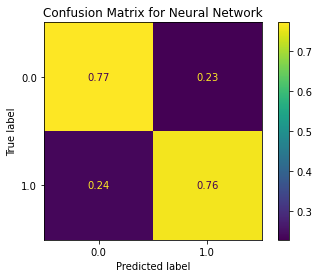

In [56]:
plot_confusion_matrix(cnn,x_test,y_test,normalize='true')
plt.title('Confusion Matrix for Neural Network')
plt.show()

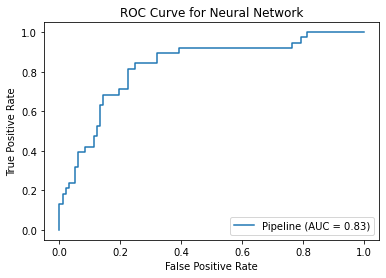

In [57]:
plot_roc_curve(cnn,x_test,y_test)
plt.title('ROC Curve for Neural Network')
plt.show()

### Random Forest

In [58]:
#Optimising model in region about default values
params = {
    'RF__n_estimators' : [i*10 for i in range(7,14)],
    'RF__criterion' : ['gini', 'entropy'],   
    'RF__min_samples_split' : [i for i in range(2,5)]
}

crf = Pipeline(steps=[
    ('SMOTE', SMOTE(random_state=927)),
    ('Numeric Transformations', preprocessor),
    ('RF', RandomForestClassifier(random_state=32))
])

gd_sr = GridSearchCV(estimator=crf,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall)
gd_sr.fit(x_train,y_train)
crf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'RF__criterion': 'entropy', 'RF__min_samples_split': 4, 'RF__n_estimators': 70}


In [59]:
print('\n')
print('Random Forest Train Data Report')
print(classification_report(y_pred = crf.predict(x_train), y_true = y_train))

print('\n')
print('Random Forest Test Data Report')
print(classification_report(y_pred = crf.predict(x_test), y_true = y_test))



Random Forest Train Data Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       553
         1.0       1.00      0.99      1.00       212

    accuracy                           1.00       765
   macro avg       1.00      1.00      1.00       765
weighted avg       1.00      1.00      1.00       765



Random Forest Test Data Report
              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88        97
         1.0       0.75      0.47      0.58        38

    accuracy                           0.81       135
   macro avg       0.78      0.71      0.73       135
weighted avg       0.80      0.81      0.79       135



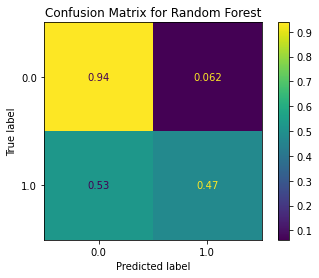

In [60]:
plot_confusion_matrix(crf, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Random Forest')
plt.show()

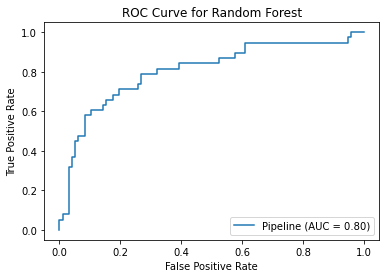

In [61]:
plot_roc_curve(crf,x_test,y_test)
plt.title('ROC Curve for Random Forest')
plt.show()

## AdaBoost

In [62]:
#Optimising model in region about default values
params = {
    'AD__n_estimators' : [i*10 for i in range(4,7)],
}

cad = Pipeline(steps=[
    ('SMOTE', SMOTE(random_state=927)),
    ('Numeric Transformations', preprocessor),
    ('AD', AdaBoostClassifier(random_state=32, base_estimator=LogisticRegression()))
])

gd_sr = GridSearchCV(estimator=cad,param_grid=params,cv=cv,n_jobs=-1,scoring = macro_recall)
gd_sr.fit(x_train,y_train)
cad = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'AD__n_estimators': 60}


In [63]:
print('\n')
print('ADA Boost Train Data Report')
print(classification_report(y_pred = cad.predict(x_train), y_true = y_train))

print('\n')
print('ADA Boost Test Data Report')
print(classification_report(y_pred = cad.predict(x_test), y_true = y_test))



ADA Boost Train Data Report
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81       553
         1.0       0.54      0.75      0.63       212

    accuracy                           0.75       765
   macro avg       0.71      0.75      0.72       765
weighted avg       0.79      0.75      0.76       765



ADA Boost Test Data Report
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82        97
         1.0       0.56      0.79      0.65        38

    accuracy                           0.76       135
   macro avg       0.73      0.77      0.74       135
weighted avg       0.80      0.76      0.77       135



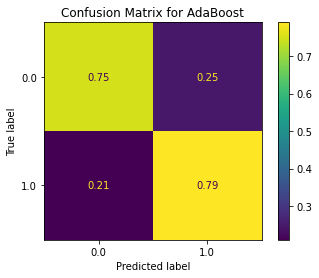

In [64]:
plot_confusion_matrix(cad, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for AdaBoost')
plt.show()

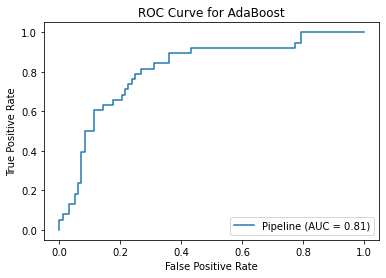

In [65]:
plot_roc_curve(cad,x_test,y_test)
plt.title('ROC Curve for AdaBoost')
plt.show()

### Voting Classifier

In [66]:
cvt = Pipeline(steps = [
    ('VC', VotingClassifier(estimators=[('ad', cad),('nn', cnn),('lr', clf)], voting='hard'))
])
cvt = cvt.fit(x_train,y_train)

In [67]:
print('\n')
print('Voting Classifier Train Data Report')
print(classification_report(y_pred = cvt.predict(x_train), y_true = y_train))

print('\n')
print('Voting Classifier Test Data Report')
print(classification_report(y_pred = cvt.predict(x_test), y_true = y_test))



Voting Classifier Train Data Report
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82       553
         1.0       0.55      0.78      0.64       212

    accuracy                           0.76       765
   macro avg       0.72      0.77      0.73       765
weighted avg       0.80      0.76      0.77       765



Voting Classifier Test Data Report
              precision    recall  f1-score   support

         0.0       0.90      0.75      0.82        97
         1.0       0.56      0.79      0.65        38

    accuracy                           0.76       135
   macro avg       0.73      0.77      0.74       135
weighted avg       0.80      0.76      0.77       135



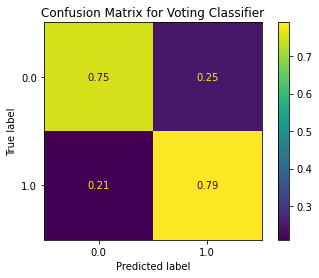

In [68]:
plot_confusion_matrix(cvt, x_test, y_test, normalize='true')
plt.title('Confusion Matrix for Voting Classifier')
plt.show()

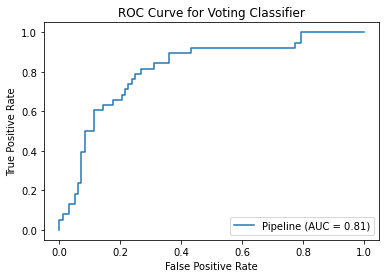

In [69]:
plot_roc_curve(cad,x_test,y_test)
plt.title('ROC Curve for Voting Classifier')
plt.show()

## Comparison of Model Performance Over Cross Validation

In [70]:
cv = KFold(n_splits=10, random_state=40, shuffle=True)
accs = {'trial' : [i for i in range(1,11)]}
rs = {'trial' : [i for i in range(1,11)]}

In [71]:
accs['Voting Classifier - Accuracy'] = cross_val_score(estimator=cvt,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Voting Classifier - Recall'] = cross_val_score(estimator=cvt,X=x_train,y=y_train,scoring=macro_recall,cv=cv,n_jobs=-1)

accs['AdaBoost - Accuracy'] = cross_val_score(estimator=cad,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['AdaBoost - Recall'] = cross_val_score(estimator=cad,X=x_train,y=y_train,scoring=macro_recall, cv=cv, n_jobs=-1)

accs['Random Forest - Accuracy'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Random Forest - Recall'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring=macro_recall, cv=cv, n_jobs=-1)

accs['Neural Network - Accuracy'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Neural Network - Recall'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring=macro_recall,cv=cv, n_jobs=-1)

accs['Decision Tree - Accuracy'] = cross_val_score(estimator=ctr,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Decision Tree - Recall'] = cross_val_score(estimator=ctr,X=x_train,y=y_train,scoring=macro_recall,cv=cv, n_jobs=-1)

accs['Logistic Regression - Accuracy'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
rs['Logistic Regression - Recall'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring=macro_recall,cv=cv, n_jobs=-1)

accs['k-Nearest Neighbours - Accuracy'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
rs['k-Nearest Neighbours - Recall'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring=macro_recall,cv=cv,n_jobs=-1)

accs['Naive Bayes - Accuracy'] = cross_val_score(estimator=cnb,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
rs['Naive Bayes - Recall'] = cross_val_score(estimator=cnb,X=x_train,y=y_train,scoring=macro_recall,cv=cv,n_jobs=-1)

accs = pd.DataFrame(accs)
rs = pd.DataFrame(rs)

In [72]:
accs

,trial,Voting Classifier - Accuracy,AdaBoost - Accuracy,Random Forest - Accuracy,Neural Network - Accuracy,Decision Tree - Accuracy,Logistic Regression - Accuracy,k-Nearest Neighbours - Accuracy,Naive Bayes - Accuracy
0,1,0.753247,0.753247,0.753247,0.727273,0.662338,0.753247,0.636364,0.376623
1,2,0.688312,0.688312,0.779221,0.675325,0.701299,0.688312,0.558442,0.415584
2,3,0.740260,0.727273,0.818182,0.727273,0.766234,0.753247,0.610390,0.402597
3,4,0.753247,0.753247,0.753247,0.714286,0.753247,0.766234,0.623377,0.441558
4,5,0.753247,0.740260,0.766234,0.766234,0.740260,0.792208,0.584416,0.324675
5,6,0.736842,0.723684,0.763158,0.763158,0.697368,0.736842,0.592105,0.407895
6,7,0.671053,0.657895,0.763158,0.736842,0.657895,0.671053,0.657895,0.434211
7,8,0.684211,0.684211,0.789474,0.684211,0.671053,0.684211,0.592105,0.315789
8,9,0.802632,0.789474,0.763158,0.776316,0.618421,0.802632,0.578947,0.447368
9,10,0.697368,0.684211,0.789474,0.684211,0.565789,0.697368,0.565789,0.394737


In [73]:
rs

,trial,Voting Classifier - Recall,AdaBoost - Recall,Random Forest - Recall,Neural Network - Recall,Decision Tree - Recall,Logistic Regression - Recall,k-Nearest Neighbours - Recall,Naive Bayes - Recall
0,1,0.726190,0.726190,0.607143,0.678571,0.559524,0.726190,0.645833,0.556548
1,2,0.692105,0.692105,0.721053,0.683333,0.603509,0.692105,0.620614,0.605263
2,3,0.739111,0.730490,0.720054,0.730490,0.685572,0.765426,0.741379,0.568058
3,4,0.729560,0.729560,0.626965,0.678459,0.695362,0.750393,0.658019,0.582940
4,5,0.696429,0.672619,0.616071,0.705357,0.657738,0.738095,0.669643,0.446429
5,6,0.712879,0.703445,0.657916,0.719442,0.610747,0.712879,0.609106,0.563167
6,7,0.665710,0.656276,0.670221,0.725185,0.582445,0.665710,0.680886,0.569729
7,8,0.662500,0.662500,0.568750,0.639583,0.585417,0.662500,0.627083,0.497917
8,9,0.810897,0.790064,0.636218,0.758013,0.541667,0.810897,0.591346,0.584936
9,10,0.761472,0.737662,0.707359,0.737662,0.479221,0.761472,0.641126,0.567100


In [74]:
rs.describe()

,trial,Voting Classifier - Recall,AdaBoost - Recall,Random Forest - Recall,Neural Network - Recall,Decision Tree - Recall,Logistic Regression - Recall,k-Nearest Neighbours - Recall,Naive Bayes - Recall
count,10.00000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,5.50000,0.719685,0.710091,0.653175,0.705610,0.600120,0.728567,0.648504,0.554209
std,3.02765,0.044863,0.041019,0.051561,0.035420,0.066689,0.046766,0.042595,0.046959
min,1.00000,0.662500,0.656276,0.568750,0.639583,0.479221,0.662500,0.591346,0.446429
25%,3.25000,0.693186,0.677491,0.618795,0.679762,0.565254,0.697299,0.622231,0.558202
50%,5.50000,0.719535,0.714818,0.647067,0.712400,0.594463,0.732143,0.643479,0.567579
75%,7.75000,0.736723,0.730257,0.698075,0.729164,0.645990,0.758702,0.666737,0.579638
max,10.00000,0.810897,0.790064,0.721053,0.758013,0.695362,0.810897,0.741379,0.605263


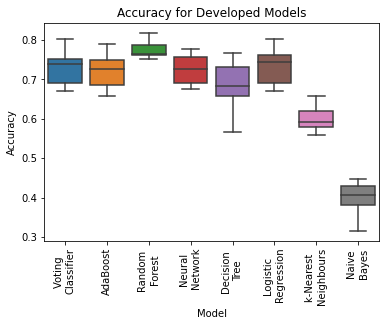

In [75]:
bplot = sb.boxplot(data=accs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Voting \nClassifier', 'AdaBoost', 'Random \nForest','Neural \nNetwork','Decision \nTree','Logistic \nRegression','k-Nearest \nNeighbours','Naive \nBayes'],rotation=90)
plt.title('Accuracy for Developed Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

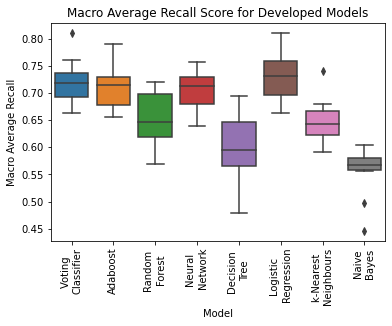

In [76]:
bplot = sb.boxplot(data=rs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Voting \nClassifier', 'Adaboost', 'Random \nForest','Neural \nNetwork','Decision \nTree','Logistic \nRegression','k-Nearest \nNeighbours','Naive \nBayes'],rotation=90)
plt.title('Macro Average Recall Score for Developed Models')
plt.xlabel('Model')
plt.ylabel('Macro Average Recall')
plt.show()

## Column Info and Saving Files to ARFF

In [77]:
arff.dump('train_test_data/train_data.arff', train_data.values, names=train_data.columns)
arff.dump('train_test_data/test_data.arff', test_data.values, names=test_data.columns)
cv = KFold(n_splits=10, random_state=40, shuffle=True)
for i, split in enumerate(cv.split(train_data)):
    arff.dump('k_fold_validation_data/kfold_train'+str(i+1)+'.arff', pd.DataFrame(train_data.iloc[split[0],:]).values, names=train_data.columns)
    arff.dump('k_fold_validation_data/kfold_test'+str(i+1)+'.arff', pd.DataFrame(train_data.iloc[split[1],:]).values, names=train_data.columns)


In [78]:
num_cols

['C6', 'C8', 'C13', 'C20', 'C26']

In [79]:
cat_cols

['C2',
 'C3',
 'C4',
 'C5',
 'C7',
 'C9',
 'C10',
 'C11',
 'C12',
 'C14',
 'C18',
 'C19',
 'C23',
 'C24',
 'C25',
 'C31',
 'C32']

# Testing Predictors on Full Dataset

In [80]:
tdata = pd.read_csv('data2020.student.csv')
tdata = tdata.loc[0:999,:]
ty_data = tdata['Class']

tdata = pd.read_csv('test.csv')
tdata = tdata.loc[0:999,:]

tdata = rfrmt.transform(tdata)
tdata = tdata.drop('Class', axis=1)

print('Classification Report for Logistic Regression on Full Dataset')
print(classification_report(y_pred = clf.predict(tdata), y_true = ty_data))

print('\nClassification Report for Voting Classifier on Full Dataset')
print(classification_report(y_pred = cvt.predict(tdata), y_true = ty_data))

Classification Report for Logistic Regression on Full Dataset
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82       720
         1.0       0.56      0.79      0.65       280

    accuracy                           0.77      1000
   macro avg       0.73      0.77      0.74      1000
weighted avg       0.81      0.77      0.78      1000


Classification Report for Voting Classifier on Full Dataset
              precision    recall  f1-score   support

         0.0       0.90      0.76      0.82       720
         1.0       0.56      0.78      0.65       280

    accuracy                           0.76      1000
   macro avg       0.73      0.77      0.74      1000
weighted avg       0.80      0.76      0.77      1000



# Making Predictions


In [81]:
tdata = pd.read_csv('data2020.student.csv')
to_pred = tdata.loc[1000:,:]

to_pred = rfrmt.transform(to_pred)
to_pred = to_pred.drop('Class', axis=1)

In [82]:
#Logistic Regression
print('Logistic Regression Prediction')
print(pd.DataFrame(clf.predict(to_pred)).value_counts())

print(clf.predict(to_pred))

Logistic Regression Prediction
1.0    52
0.0    48
dtype: int64
[0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0.]


In [83]:
#Voting Classifier Prediction
print('Voting Classifier Prediction')
print(pd.DataFrame(cvt.predict(to_pred)).value_counts())

print(cvt.predict(to_pred))

Voting Classifier Prediction
1.0    51
0.0    49
dtype: int64
[0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 0.]


# Pickling Classifiers

In [84]:
with open('classifiers.pkl', 'wb') as fstrm:
    pkl.dump([clf, cvt], fstrm)